# Information-Maximizing GAN (InfoGAN)




What if there is a way of disentangling the learned representation space of the Generator without directly conditioning the data on labels? What if we don't have labels but we can assume there is some similarity in the data such as 0-9 digits in the case of MNIST? The <a href="https://arxiv.org/pdf/1606.03657.pdf">Information-Maximizing GAN (InfoGAN)</a> proposes to do exactly this. 

We add feed both noise $z$ and a latent code $c$ to the generator, and ensure that the generator uses the latent code by enforcing a regularization term: there should be high mutual information between the input code $c$ and the output $G(z, c)$. With scalar $\lambda$, this changes the GAN objective as follows:


$$
\large{
\underset{G}{\min} \underset{D}{\max} V_{I}(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z), c \sim p_c(c)}[\log (1 - D(G(z, c)))] - \lambda I(c ; G(z, c))
}
$$


However, we don't typically have access to the posterior $p(c|x)$ and instead take <a href="http://aivalley.com/Papers/MI_NIPS_final.pdf">a variational approach</a> by introducing an auxilary distribution $Q(c|x)$ to approximate the posterior. This results in a lower bound on the mutual information:

$$
\large I(c ; G(z, c)) \geq \mathbb{E}_{c \sim p(c), \hat{x} \sim G(z, c)}[\log Q(c|\hat{x})] + H(c) = L_{I}(G, Q)
$$

We then add this lower bound (but treat the entropy on the code as a constant and ignore it) to the GAN objective to find a tractable solution to maximizing the mutual information:


$$
\large{
\underset{G, Q}{\min} \underset{D}{\max} V_{\text{InfoGAN}}(D, G, Q) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z), c \sim p_c(c)}[\log (1 - D(G(z, c)))] - \lambda L_{I}(G, Q)
}
$$


In terms of implementation, the overhead is quite small. We add an extra output to the discriminator (the Q head), and calculate the loss in terms of mutual information in addition to the typical loss. The authors note that the mutual information approximation typically converges faster than the GAN loss itself, which is why the learned representation basically comes for free.

In [ ]:
# Get the latest JAX, jaxlib and Flax
# !pip install --upgrade -q jax jaxlib
!pip install --upgrade -q flax

import jax
import flax

import jax.numpy as jnp
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from IPython.display import clear_output
from jax.nn.initializers import normal as normal_init
from flax import linen as nn

## Loading MNIST

In [ ]:
def set_range(batch):
  batch = tf.image.convert_image_dtype(batch['image'], tf.float32)
  batch = (batch - 0.5) / 0.5  # tanh range is -1, 1
  return batch
 

mnist_data = tfds.load("mnist")['train']
batches_in_epoch = len(mnist_data) // 128
 
data_gen = iter(tfds.as_numpy(
      mnist_data
        .map(set_range)
        .cache()
        .shuffle(len(mnist_data), seed=41)
        .repeat()
        .batch(128)
 ))

## Flax Linen Architecture

In [ ]:
class Generator(nn.Module):
  features: int = 64
  training: bool = True

  @nn.compact
  def __call__(self, z):
    z = z.reshape((z.shape[0], 1, 1, z.shape[1]))
    x = nn.ConvTranspose(self.features*4, [3, 3], [2, 2], 'VALID', kernel_init=normal_init(0.02))(z)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(self.features*2, [4, 4], [1, 1], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(self.features, [3, 3], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(1, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = jnp.tanh(x)
    return x


class Discriminator(nn.Module):
  features: int = 64
  training: bool = True

  q_cat: int = 10

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(self.features, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Conv(self.features*2, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.leaky_relu(x, 0.2)
    
    # Discriminator output
    d = nn.Conv(1, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    d = d.reshape((d.shape[0], -1))

    # Q outpiut
    q = nn.Conv(self.features*2, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    q = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(q)
    q = nn.leaky_relu(q, 0.2)
    q = nn.Conv(self.q_cat, [1, 1], [2, 2], 'VALID', kernel_init=normal_init(0.02))(q)
    q = q.reshape((q.shape[0], -1))
    return d, q


def sample_latent(key, shape_noise, shape_cat):
  noise_key, cat_key = jax.random.split(key, 2)
  
  # Sample irreducible noise
  noise = jax.random.normal(noise_key, shape_noise)

  # Sample categorical latent code
  code_cat = jax.random.randint(cat_key, shape_cat, 0, 10)
  code_cat = jax.nn.one_hot(code_cat, 10)

  latent = jnp.concatenate([noise, code_cat], axis=-1)

  return latent, code_cat

## Loss Functions

In [ ]:
def bce_logits(logit, label):
  """
  Implements the BCE with logits loss, as described:
  https://github.com/pytorch/pytorch/issues/751
  """
  neg_abs = -jnp.abs(logit)
  batch_bce = jnp.maximum(logit, 0) - logit * label + jnp.log(1 + jnp.exp(neg_abs))
  return jnp.mean(batch_bce)


def loss_mutual_information(code_cat, q_cat):
  cat_loss = -jnp.mean(jnp.sum(code_cat * q_cat, axis=-1))
  mi_loss = cat_loss
  return mi_loss


def loss_generator(params_g, params_d, vars_g, vars_d, data, key):
  batch_size = data.shape[0]
  latent, code_cat = sample_latent(key, (batch_size, 64), (batch_size, ))

  fake_data, vars_g = Generator().apply(
      {'params': params_g, 'batch_stats': vars_g['batch_stats']},
      latent, mutable=['batch_stats']
  )

  (preds, q), vars_d = Discriminator().apply(
      {'params': params_d, 'batch_stats': vars_d['batch_stats']},
      fake_data, mutable=['batch_stats']
  )

  # Calculate Mutual Information loss
  q_cat = nn.log_softmax(q, axis=-1)
  loss_mi = loss_mutual_information(code_cat, q_cat)

  # Calculate Discriminator loss
  loss_d = -jnp.mean(jnp.log(nn.sigmoid(preds)))

  loss = loss_d + loss_mi
  return loss, (vars_g, vars_d)


def loss_discriminator(params_d, params_g, vars_g, vars_d, data, key):
  batch_size = data.shape[0]
  latent, code_cat = sample_latent(key, (batch_size, 64), (batch_size, ))

  fake_data, vars_g = Generator().apply(
      {'params': params_g, 'batch_stats': vars_g['batch_stats']},
      latent, mutable=['batch_stats']
  )

  (fake_preds, q), vars_d = Discriminator().apply(
      {'params': params_d, 'batch_stats': vars_d['batch_stats']},
      fake_data, mutable=['batch_stats']
  )
  (real_preds, _), vars_d = Discriminator().apply(
      {'params': params_d, 'batch_stats': vars_d['batch_stats']},
      data, mutable=['batch_stats']
  )

  # Calculate Mutual Information loss
  q_cat = nn.log_softmax(q, axis=-1)
  loss_mi = loss_mutual_information(code_cat, q_cat)

  real_loss = bce_logits(real_preds, jnp.ones((batch_size,), dtype=jnp.int32))
  fake_loss = bce_logits(fake_preds, jnp.zeros((batch_size,), dtype=jnp.int32))

  loss = (real_loss + fake_loss) / 2 + loss_mi

  return loss, (vars_g, vars_d)

## Define the training step

In [ ]:
@jax.jit
def train_step(data, vars_g, vars_d, optim_g, optim_d, key):
  key, key_gen, key_disc = jax.random.split(key, 3)

  # Train the discriminator
  grad_fn_discriminator = jax.value_and_grad(loss_discriminator, has_aux=True)
  (loss_d, (vars_g, vars_d)), grad_d = grad_fn_discriminator(
      optim_d.target, optim_g.target, vars_g, vars_d, data, key_disc
  )
  optim_d = optim_d.apply_gradient(grad_d)

  # Train the generator
  grad_fn_generator = jax.value_and_grad(loss_generator, has_aux=True)
  (loss_g, (vars_g, vars_d)), grad_g = grad_fn_generator(
      optim_g.target, optim_d.target, vars_g, vars_d, data, key_gen
  )

  optim_g = optim_g.apply_gradient(grad_g)

  loss = {'generator': loss_g, 'discriminator': loss_d}

  return loss, vars_g, vars_d, optim_g, optim_d, key


@jax.jit
def eval_step(params, vars, latent):  
  fake_data, _ = Generator(training=False).apply(
      {'params': params, 'batch_stats': vars['batch_stats']},
      latent, mutable=['batch_stats']
  )

  return fake_data

## Training the model

In [ ]:
def plot(images, loss, epoch):
  clear_output(True)

  # First plot the losses.
  fig, ax = plt.subplots(figsize=(10, 4))
  ax.plot(loss['generator'], label='Generator Loss')
  ax.plot(loss['discriminator'], label='Discriminator Loss')
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  fig.suptitle(f"Epoch {epoch}")

  # Next, plot the static samples.
  fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10), tight_layout=bool)
  for ax, image in zip(sum(axes.tolist(), []), images):
    ax.imshow(image[:, :, 0], cmap='gray')
    ax.set_axis_off()

  plt.show()

In [ ]:
key = jax.random.PRNGKey(seed=41)
key, key_gen, key_disc, key_latent = jax.random.split(key, 4)

# Retrieve shapes for generator and discriminator input.
noise = jax.random.normal(key, (100, 64))
c = jnp.tile(jnp.arange(10), 10)
c = jax.nn.one_hot(c, 10)
latent = jnp.concatenate([noise, c], axis=-1)
image_shape = next(data_gen).shape

# Generate initial variables (parameters and batch statistics).
vars_g = Generator().init(key_gen, jnp.ones(latent.shape, jnp.float32))
vars_d = Discriminator().init(key_disc, jnp.ones(image_shape, jnp.float32))

# Create optimizers.
optim_g = flax.optim.Adam(0.0001, 0.5, 0.999).create(vars_g['params'])
optim_d = flax.optim.Adam(0.0002, 0.5, 0.999).create(vars_d['params'])

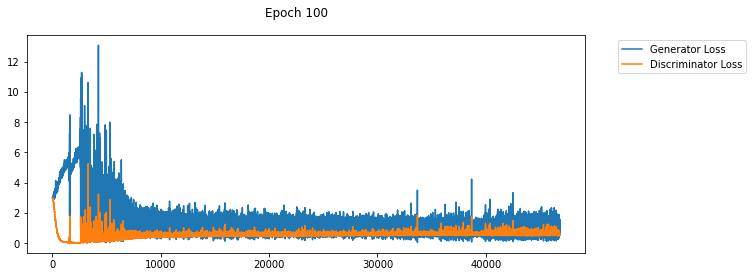

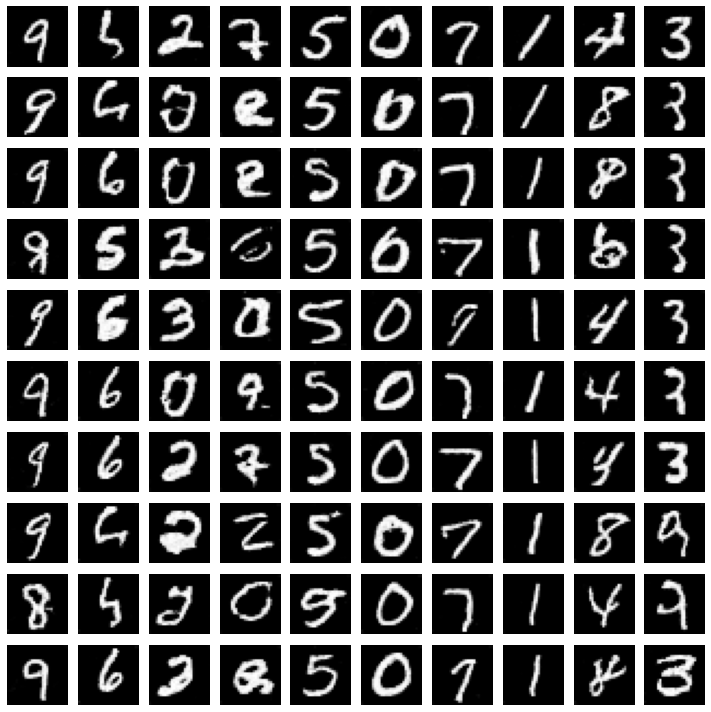

In [ ]:
loss = {'generator': [], 'discriminator': []}

for epoch in range(1, 101):
  for batch in range(batches_in_epoch):
    data = next(data_gen)

    batch_loss, vars_g, vars_d, optim_g, optim_d, key = train_step(
        data, vars_g, vars_d, optim_g, optim_d, key
    )

    loss['generator'].append(batch_loss['generator'])
    loss['discriminator'].append(batch_loss['discriminator'])
   
  sample = eval_step(optim_g.target, vars_g, latent)
  plot(sample, loss, epoch)

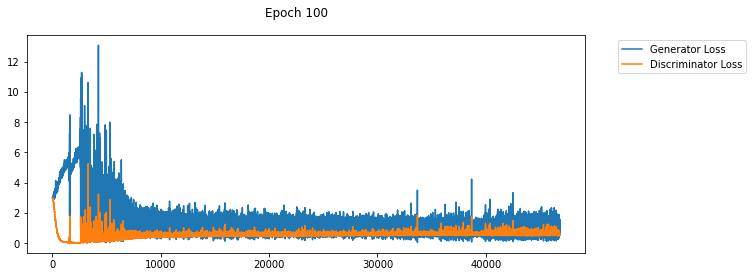

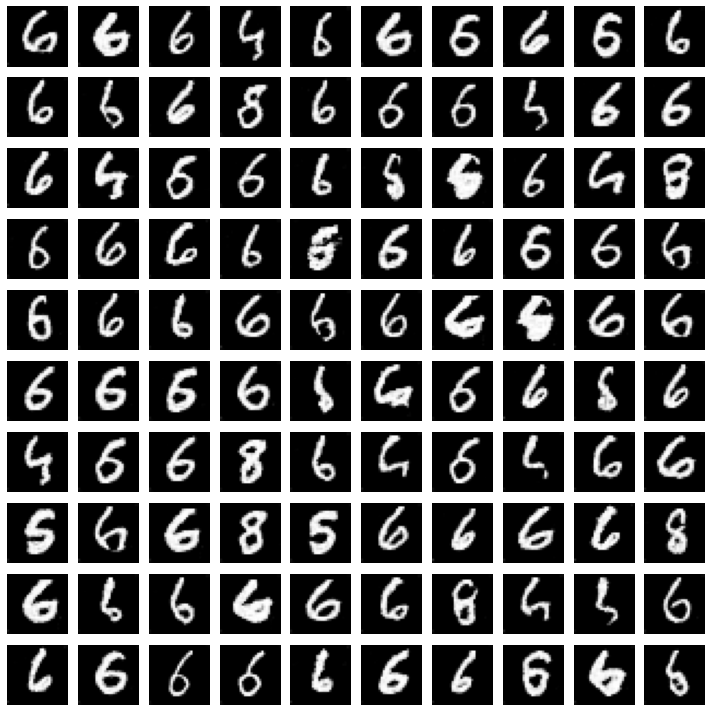

In [ ]:
key_noise, key = jax.random.split(key, 2)

noise = jax.random.normal(key_noise, (100, 64))
c = jnp.ones((100,))
c = jax.nn.one_hot(c, 10)
latent = jnp.concatenate([noise, c], axis=-1)

sample = eval_step(optim_g.target, vars_g, latent)
plot(sample, loss, epoch)

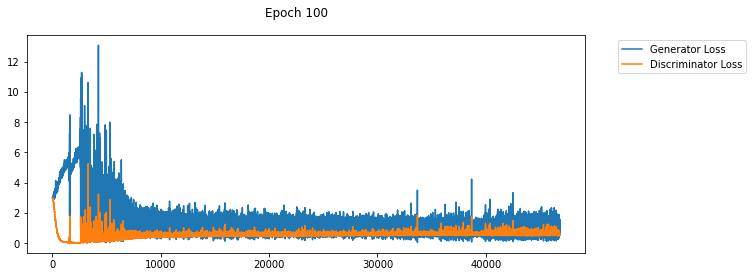

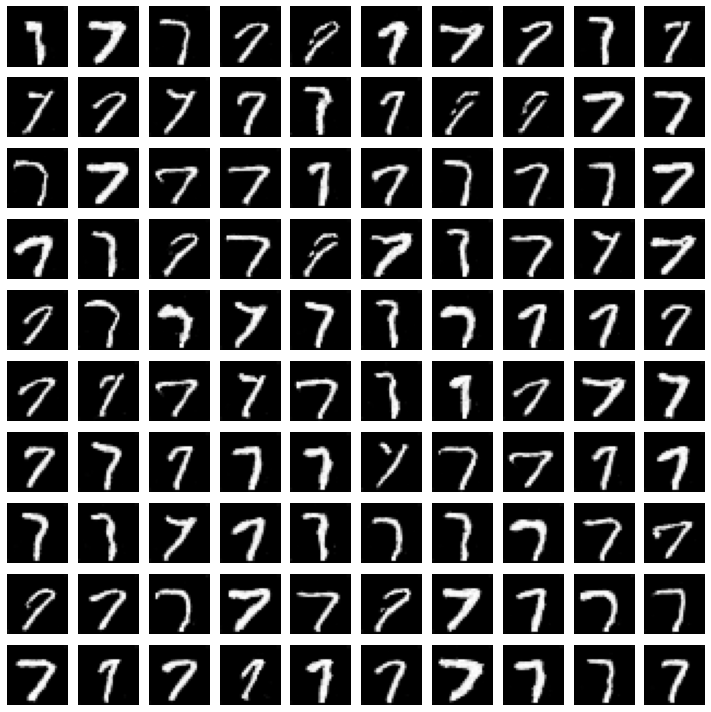

In [ ]:
key_noise, key = jax.random.split(key, 2)

noise = jax.random.normal(key_noise, (100, 64))
c = jnp.ones((100,)) + 5
c = jax.nn.one_hot(c, 10)
latent = jnp.concatenate([noise, c], axis=-1)

sample = eval_step(optim_g.target, vars_g, latent)
plot(sample, loss, epoch)